# Construisez, exécutez et testez votre service à l'aide de Docker

Après avoir conçu un microservice RESTful fonctionnel dans le guide précédent, nous verrons dans ce guide comment l'utiliser à la manière de Docker, en encapsulant le service dans un conteneur autonome afin qu'il soit immuable et puisse être déployé tout seul. Ce guide décrit très explicitement les dépendances du service et les manières dont il peut être utilisé. Le principal moyen d'exécuter un service consiste à l'exécuter en tant que serveur Web, mais d'autres opérations sont possibles, telles que l'exécution de tests unitaires, la génération de rapports, etc. Nous verrons également comment déployer le service sur votre ordinateur local pour le tester et comment le partager via un référentiel d'images.

Les sujets suivants seront traités dans ce chapitre
 
* Construire votre service avec un Dockerfile
* Faire fonctionner avec un conteneur immuable
* Configurer votre service
* Déployer le service Docker localement
* Envoyer votre image Docker vers un registre distant


À la fin du guide, vous saurez comment utiliser Docker, créer un service de base, créer une image et l'exécuter. Vous saurez également comment partager l'image à exécuter sur un autre ordinateur

In [12]:
! docker version

Client: Docker Engine - Community
 Version:           20.10.11
 API version:       1.41
 Go version:        go1.16.9
 Git commit:        dea9396
 Built:             Thu Nov 18 00:37:08 2021
 OS/Arch:           linux/amd64
 Context:           default
 Experimental:      true
Cannot connect to the Docker daemon at unix:///var/run/docker.sock. Is the docker daemon running?


## Construire votre service avec un Dockerfile

Tout commence par un conteneur. Comme nous l'avons dit, les conteneurs sont un ensemble de logiciels en paquets, encapsulé de manière standard. Ce sont des unités logicielles qui peuvent être exécutées indépendamment, car elles sont totalement autonomes. Pour faire un conteneur, nous devons le construire

Pour construire un conteneur avec Docker, nous avons besoin d'une définition de son contenu. Le système de fichiers est créé en appliquant couche après couche. Chaque Dockerfile, la recette pour générer un conteneur, contient une définition des étapes pour générer un conteneur. 

Par exemple, créons un Dockerfile très simple. Créez un fichier nommé example.txt avec un exemple de texte et un autre nommé Dockerfile.simple avec ce qui suit :


    # scratch is a special container that is totally empty
    FROM scratch
    COPY example.txt /example.txt

Maintenant, construisez-le à l'aide de la commande suivante :


     # docker build -f <dockerfile> --tag <tag> <context>
     $  docker build -f Dockerfile.simple --tag simple .

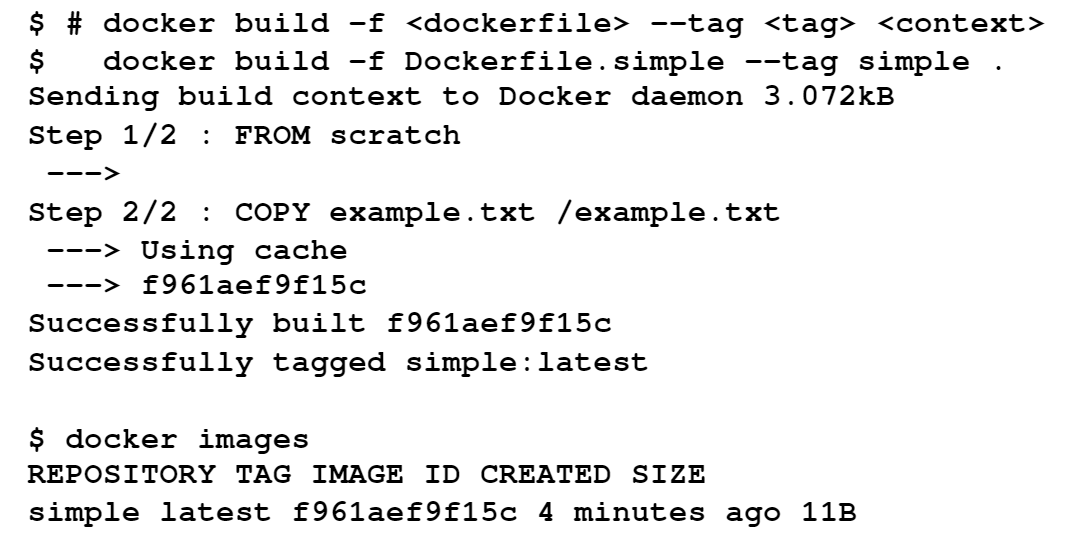

Cela crée une image Docker qui contient uniquement le fichier example.txt. Ce n'est pas très utile, mais assez petit—seulement 11 octets. C'est parce qu'il hérite du conteneur vide, scratch. Il copie ensuite le fichier example.txt à l'intérieur de l'emplacement du conteneur/example.txt.

Jetons un coup d'œil à la commande docker build. Le Dockerfile est défini avec le paramètre -f, la balise de l'image résultante est définie avec --tag et le paramètre de contexte est défini comme point (.). Le paramètre context est la référence où rechercher les fichiers définis dans les étapes du Dockerfile


L'image a également l'ID d'image f961aef9f15c, qui est attribué automatiquement. Il s'agit du contenu du système de fichiers. Nous verrons plus tard pourquoi cela est pertinent.

## Exécuter des commandes

Le conteneur précédent n'était pas très excitant. Il est définitivement possible de créer votre propre conteneur à partir de zéro, mais, en général, vous chercherez une base de référence qui contient une sorte de distribution Linux qui vous permet de faire quelque chose d'utile avec le conteneur.

 Comme nous l'avons vu avec la commande FROM, nous pouvons commencer avec un conteneur précédent. Nous utiliserons la distribution Alpine Linux (https://alpinelinux.org/) tout au long du guide, bien que d'autres distributions soient disponibles, telles que Ubuntu et CentOS. Consultez l'article sur https://sweetcode.io/linux-distributions-optimized-hosting-docker/   pour les distributions destinées aux conteneurs Docker.


    Pourquoi Alpine Linux ? C'est sans doute la distribution la plus populaire
    pour les systèmes Docker car elle a une très petite empreinte et elle vise
    la sécurité. Il est bien entretenu et régulièrement mis à jour et corrigé
    Il dispose également d'un système complet de gestion de packages qui vous
    permet d'installer facilement la plupart des outils courants pour les
    services Web. L'image de base n'a qu'une taille d'environ 5 Mo et contient
    un système d'exploitation Linux fonctionnel


Le fichier Docker suivant héritera du conteneur alpin de base et ajoutera le fichier exemple.txt :



    FROM alpine

    RUN mkdir -p /opt/
    COPY example.txt /opt/example.txt

Ce conteneur nous permet d'exécuter des commandes, car les utilitaires de ligne de commande habituels sont inclus :


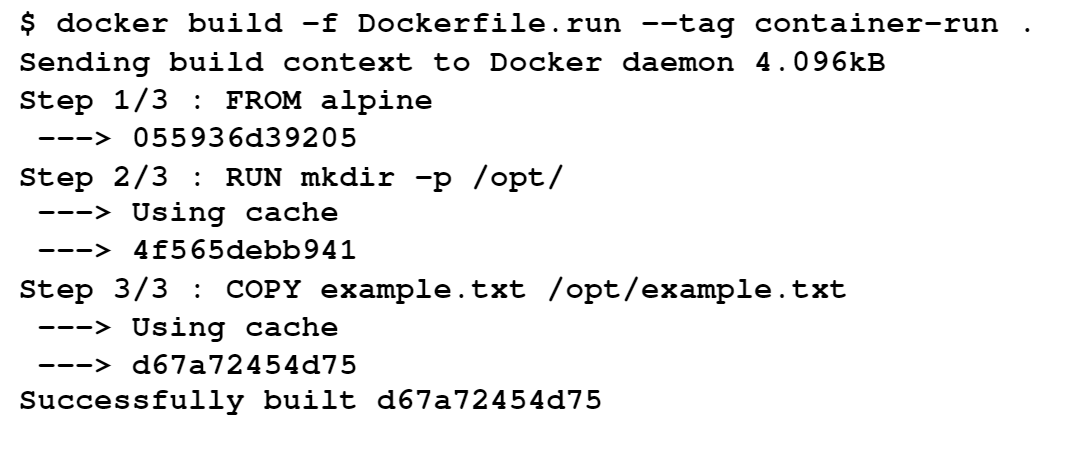

    $   docker run container-run cat /opt/example.txt
    An example file

Notez comment la ligne de commande cat /opt/example.txt est exécutée. Cela se passe réellement à l'intérieur du conteneur. Nous imprimons le résultat dans stdout dans notre console stdout. Cependant, si un fichier est créé, lorsque le conteneur s'arrête, le fichier n'est pas enregistré dans notre système de fichiers local, mais uniquement à l'intérieur du conteneur 


Le fichier est en fait enregistré dans un conteneur arrêté. Une fois que le conteneur a terminé son exécution, il reste arrêté par Docker jusqu'à ce qu'il soit supprimé. Vous pouvez voir le conteneur arrêté avec la commande docker ps -a. Un conteneur arrêté n'est pas très intéressant, bien que son système de fichiers soit sauvegardé sur disque.


Vous pouvez ajouter une commande par défaut, qui sera exécutée lorsqu'aucune commande n'est donnée, en ajoutant ce qui suit :

  
    CMD cat /opt/example.txt

Faites-le s'exécuter automatiquement en utilisant la commande suivante :

    
    $ docker run container-run
    An example file

La définition d'une commande standard rend le conteneur vraiment simple. Exécutez-le simplement et il fera tout ce pour quoi il est configuré. N'oubliez pas d'inclure une commande par défaut dans vos conteneurs.

Nous pouvons également exécuter un shell dans le conteneur et interagir avec lui. N'oubliez pas d'ajouter le drapeau -it pour garder la connexion correctement ouverte, -i pour garder stdin ouvert et -t pour créer un apseudo Terminal, vous pouvez vous en souvenir en tant que Terminal interactif :

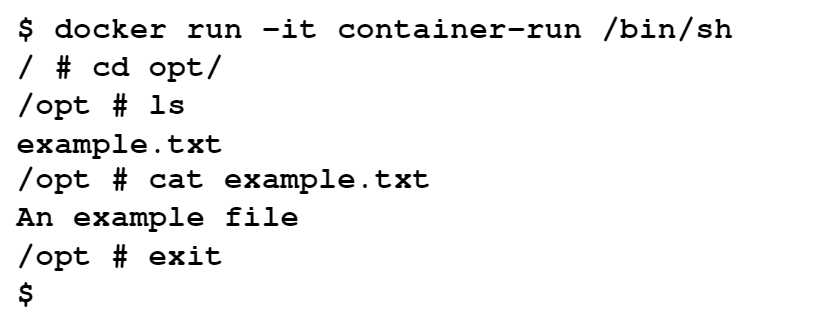

## Comprendre le cache Docker 

L'un des principaux points de confusion lors de la création d'images est de comprendre le fonctionnement des couches Docker. Chacune des commandes d'un fichier Docker est exécutée consécutivement et au-dessus de la couche précédente. Si vous êtes à l'aise avec Git, vous remarquerez que le processus est similaire. Chaque couche stocke uniquement les modifications apportées à l'étape précédente :

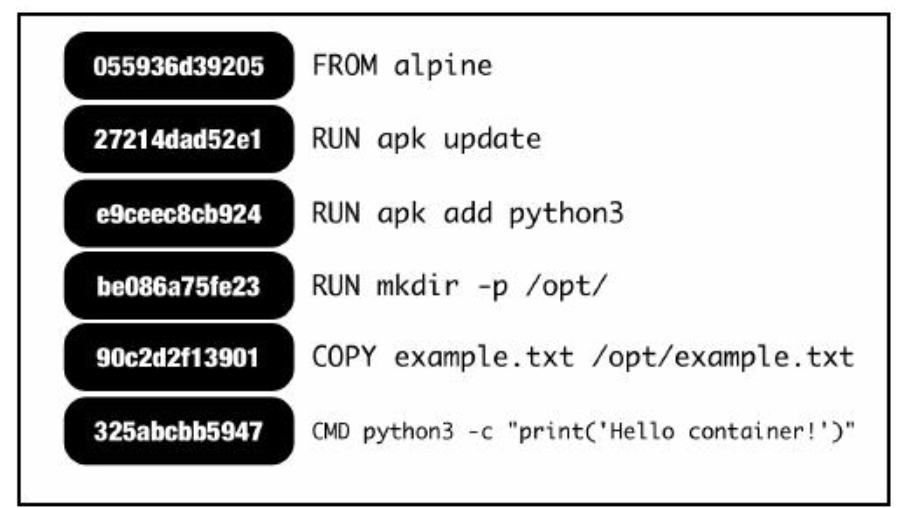

Cela permet à Docker de mettre en cache de manière assez agressive, car toute couche avant un changement est déjà calculée. Par exemple, dans cet exemple, nous mettons à jour les packages disponibles avec apkupdate, puis installons le package python3, avant de copier le fichier example.txt. Toute modification apportée au fichier example.txt n'exécutera que la superposition des deux dernières étapes be086a75fe23. Cela accélère la reconstruction des images.



Cela signifie également que vous devez construire vos fichiers Docker avec soin pour ne pas invalider le cache. Commencez par les opérations qui changent très rarement, comme l'installation des dépendances du projet, et terminez par celles qui changent le plus souvent, comme l'ajout de votre code. Le Dockerfile annoté pour notre exemple contient des indications sur l'utilisation du cache. Cela signifie également que une image ne sera jamais plus petite en taille, ajoutant une nouvelle couche même si la couche supprime des données, car la couche précédente est toujours stockée sur le disque. Si vous souhaitez supprimer les embrouilles d'une étape, vous devrez le faire au cours de la même étape.


    Garder vos conteneurs petits est très important. Dans n'importe quel
    système Docker, la tendance est d'avoir un tas de conteneurs et beaucoup
    d'images. Bigimages sans raison remplira rapidement les dépôts. Ils seront
    lents à télécharger et à envoyer, et également à démarrer, car le conteneur
    est copié dans votre infrastructure. 
    
    Il y a une autre considération pratique. Les conteneurs sont un excellent
    outil pour simplifier et réduire votre service au minimum. Avec un peu
    d'investissement, vous obtiendrez d'excellents résultats et conserverez des
    contenants petits et précis.

Il existe plusieurs pratiques pour garder vos images petites. Outre le fait de veiller à ne pas installer d'éléments supplémentaires, les principaux sont la création d'une couche unique et compliquée qui s'installe et se désinstalle, ainsi que des images en plusieurs étapes. Les Dockerfiles à plusieurs étapes sont un moyen de faire référence à une couche intermédiaire précédente et de copier des données à partir de là. Consulter la documentation Docker
(https://docs.docker.com/develop/develop-images/multistage-build/)

Vous pouvez en savoir plus sur les différences entre les deux stratégies dans cet article : https://pythonspeed.com/articles/smaller-python-docker-images/  .

## Construire un conteneur de services Web

Nous avons un objectif spécifique, créer un conteneur capable d'exécuter notre microservice, ThoughtsBackend. Pour ce faire, nous avons quelques exigences :

* nous devons copier notre code dans le conteneur. 
* Le code doit être servi via un serveur Web. 

Ainsi, en gros, nous devons créer un conteneur avec un serveur Web, ajouter notre code, configurez-le pour qu'il exécute notre code et servez le résultat lors du démarrage du conteneur.

En tant que serveur Web, nous utiliserons uWSGI (https://uwsgi-docs.readthedocs.io/en/latest/  ).

uWSGI est un serveur Web capable de servir notre application Flask via le WSGI protocol.uWSGI est assez configurable, a beaucoup d'options et est capable de servir HTTP directement.

    Une configuration très courante consiste à avoir NGINX devant uWSGI pour
    servir des fichiers statiques, car c'est plus efficace pour cela. Dans
    notre cas d'utilisation spécifique, nous ne servons pas beaucoup de
    fichiers statiques, car nous exécutons une API RESTful et, dans notre
    architecture principale, il y a déjà une charge équilibreur sur le frontend
     et serveur de fichiers statiques dédié. Cela signifie que nous n'ajouterons pas
    de composant supplémentaire pour plus de simplicité. NGINX communique
    généralement avec uWSGI à l'aide du protocole uwsgi, qui est un protocole
    spécifiquement pour le serveur uWSGI, mais il peut également le faire via
    HTTP. Consultez la documentation NGINX et uWSGI.


Jetons un coup d'œil au fichier docker/app/Dockerfile. Il a deux étapes; la première consiste à compiler les dépendances :



      ######### This image will compile the dependencies
      # It will install compilers and other packages, that won't be carried
      # over to the runtime image
      ########
      
      FROM alpine:3.9 AS compile-image
      
      # Add requirements for python and pip
      RUN apk add --update python3

      RUN mkdir -p /opt/code
      
      WORKDIR /opt/code
      
      # Install dependencies
      RUN apk add python3-dev build-base gcc linux-headers postgresql-dev libffi-dev
      
      
      # Create a virtual environment for all the Python dependencies
      RUN python3 -m venv /opt/venv
      
      # Make sure we use the virtualenv:
      ENV PATH="/opt/venv/bin:$PATH"
      
      RUN pip3 install --upgrade pip
      
      # Install and compile uwsgi
      RUN pip3 install uwsgi==2.0.18
      
      # Install other dependencies
      
      COPY ThoughtsBackend/requirements.txt /opt/RUN 
      
      pip3 install -r /opt/requirements.txt

  
Cette étape fait les étapes suivantes :

* 1. Nomme l'image de compilation de scène, héritant d'Alpine
* 2. Installs python3.
* 3. Installe les dépendances de construction, y compris le compilateur gcc et les en-têtes Python3.(python3-dev)
* 4.  Crée un nouvel environnement virtuel. Nous allons installer toutes les dépendances Python ici
* L'environnement virtuel est activé
* installe uWSGI. Cette étape le compile à partir du code

    
    Vous pouvez également installer le package uWSGI inclus dans la
    distribution Alpine, mais j'ai trouvé le package compilé plus complet et
    plus facile à configurer, car le package Alpine uwsgi vous oblige à
    installer d'autres packages tels que uwsgi-python3, uwsgi-http, etc. puis
    activez le plugin dans la configuration uWSGI. La différence de taille est
    minime. Cela vous permet également d'utiliser la dernière version d'uWSGI
    et de ne pas dépendre de celle de votre distribution Alpine

* 7. Copiez le fichier requirements.txt et installez toutes les dépendances. Cela compilera et copiera les dépendances dans l'environnement virtuel


La deuxième étape consiste à préparer le conteneur en cours d'exécution. Nous allons jeter un coup d'oeil:


    ########
    # This image is the runtime, will copy the dependencies from the other
    ########
    FROM alpine:3.9 AS runtime-image
    
    
    # Install python
    RUN apk add --update python3 curl libffi postgresql-libs
    
    # Copy uWSGI configuration
    RUN mkdir -p /opt/uwsgi
    ADD docker/app/uwsgi.ini /opt/uwsgi/
    ADD docker/app/start_server.sh /opt/uwsgi/
    
    
    # Create a user to run the service
    RUN addgroup -S uwsgi
    RUN adduser -H -D -S uwsgi
    USER uwsgi
    
    # Copy the venv with compile dependencies from the compile-image
    COPY --chown=uwsgi:uwsgi --from=compile-image /opt/venv /opt/venv
    
    # Be sure to activate the venv
    ENV PATH="/opt/venv/bin:$PATH"
    
    # Copy the code
    COPY --chown=uwsgi:uwsgi ThoughtsBackend/ /opt/code/
    
    # Run parameters
    WORKDIR /opt/code
    EXPOSE 8000
    CMD ["/bin/sh", "/opt/uwsgi/start_server.sh"]


Il réalise les actions suivantes :

* 1. Étiquete l'image en tant qu'image d'exécution et hérite d'Alpine, comme précédemment

* 2. Installe Python et d'autres exigences pour le runtime
* 3. Copiez la configuration et le script uWSGI pour démarrer le service. Nous allons y jeter un œil dans un instant.

* 4. Créez un utilisateur pour exécuter le service et définissez-le par défaut à l'aide de la commande USER


    Cette étape n'est pas strictement nécessaire car, par défaut, l'utilisateur
    root sera utilisé. Comme nos conteneurs sont isolés, obtenir un accès root
    dans l'un est intrinsèquement plus sécurisé que dans un vrai serveur.
    Dans tous les cas, il est recommandé de ne pas configurer notre service
    public en accédant en tant que root et cela supprimera certains
    avertissements compréhensibles.

* 5. Copiez l'environnement virtuel à partir de l'image d'image compilée. Cela installe tous les packages Python compilés. A noter qu'ils sont copiés avec l'utilisateur pour exécuter le service, pour y avoir accès. L'environnement virtuel est activé.

* 6. Copiez le code de l'application

* .7 Définissez les paramètres d'exécution. Notez que le port 8000 est exposé. Ce sera le port sur lequel nous servirons l'application

Notez que le code de l'application est copié à la fin du fichier. Le code de l'application va probablement être le code qui change le plus souvent, donc cette structure profite du cache Docker et ne recrée que les très rares dernières couches, au lieu de devoir recommencer depuis le début. Tenez-en compte lors de la conception de vos Dockerfiles.

Construisons notre conteneur maintenant. Voir qu'il y a deux images créées, bien qu'une seule soit nommée. L'autre est l'image de compilation, qui est beaucoup plus grande car elle contient les compilateurs, et ainsi de suite :


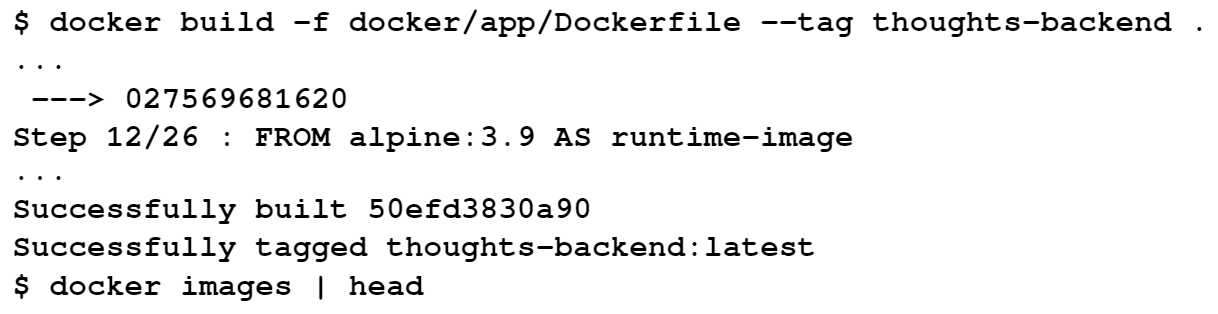

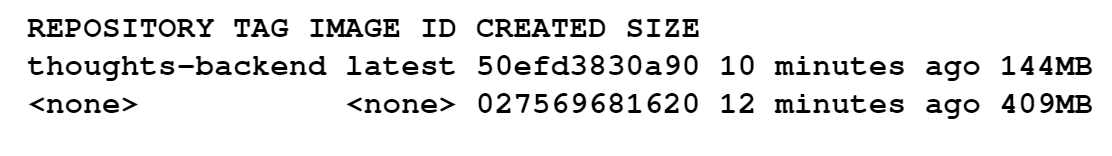



Nous pouvons maintenant exécuter le conteneur. Pour pouvoir accéder au port interne 8000, nous devons le router avec l'option -p :

    $ docker run -it  -p 127.0.0.1:8000:8000/tcp thoughts-backend

L'accès à notre navigateur local à 127.0.0.1 montre notre application. Vous pouvez voir les accesslogs dans la sortie standard :

## Configuration de uWSGI

Le fichier uwsgi.ini contient la configuration uWSGI :


    [uwsgi]
    uid=uwsgi
    chdir=/opt/code
    wsgi-file=wsgi.py
    master=True
    pidfile=/tmp/uwsgi.pid
    http=:8000
    vacuum=True
    processes=1
    max-requests=5000
    # Used to send commands to uWSGI
    master-fifo=/tmp/uwsgi-fifo

La plupart de ces informations proviennent du fichier Docker, bien qu'elles doivent correspondre pour que uWSGI sache où trouver le code de l'application, le nom du fichier WSGI à démarrer, l'utilisateur à partir duquel le démarrer, etc. Les autres paramètres sont spécifiques au comportement uWSGI


* master : crée un processus maître qui contrôle les autres. Opération foruWSGI recommandée car elle crée une opération plus fluide.
* http : Sert dans le port spécifié. Le mode HTTP crée un processus qui équilibre la charge des requêtes HTTP vers les travailleurs, et il est recommandé de servir HTTP en dehors du conteneur.
* processes : le nombre de travailleurs de l'application. Notez que, dans notre configuration, cela signifie en fait trois processus : un maître, un HTTP et un travailleur. Plus de travailleurs peuvent gérer plus de requêtes mais utiliseront plus de mémoire. En production, vous devrez trouver le nombre qui vous convient, en le comparant au nombre de conteneurs. 

* max-requests : une fois qu'un travailleur a traité ce nombre de demandes, recyclez-le (arrêtez-le et démarrez-en un nouveau). Cela réduit la probabilité de memoryleaks.

* vacuum : nettoie l'environnement en quittant.
* master-fifo : crée un tube Unix pour envoyer des commandes à uWSGI. Nous utiliserons ceci pour gérer les arrêts gracieux


Pour permettre des arrêts gracieux, nous encapsulons l'exécution de uWSGI dans notre script start_server.sh :


Docker utilise le signal SIGTERM pour arrêter l'exécution des conteneurs. Après un délai d'attente, il les tuera avec SIGKILL.

## Commandes Docker efreshing

Nous avons examiné certaines des commandes Docker importantes : 

* docker build : crée une imagedocker run : exécute une image
* docker exec : exécute une commande dans un container docker en cours d'exécution 
* docker ps : affiche les images containers docker en cours d'exécution

* docker images : affiche les images existantes 

bien que ce soient les basiques, connaître la plupart des commandes Docker disponibles est très utile pour déboguer les problèmes et effectuer des opérations telles que la surveillance, la copie et le marquage d'images, la création de réseaux, etc. Ces commandes vous montreront également beaucoup de choses sur le fonctionnement interne de Docker.

## Fonctionner avec un containerDocker immuable 

Les commandes telles que celles vues plus tôt dans ce guide sont la base, là où tout commence. Mais, lorsqu'il s'agit de plus d'un, cela commence à devenir compliqué de les gérer. 

Vous avez vu que certaines commandes peuvent être assez longues. Pour opérer avec un conteneur dans une opération en cluster, nous utiliserons docker-compose. Il s'agit de l'outil d'orchestration de Docker pour définir des opérations multi-conteneurs. Il est défini par un fichier YAML avec toutes les différentes tâches et services, chacun avec suffisamment de contexte pour le construire et l'exécuter. Il vous permet de stocker les différents services et paramètres pour chacun d'eux dans ce fichier de configuration, appelé docker-compose.yaml par défaut. Cela vous permet de les coordonner et de générer un cluster de services réplicable

##Tester le conteneur

Nous allons commencer par créer un service pour exécuter les tests unitaires. Gardez à l'esprit que les tests doivent être exécutés à l'intérieur du conteneur. Cela normalisera leur exécution et garantira que les dépendances sont constantes.

    Notez que, dans la création de notre conteneur, nous incluons toutes les
    exigences pour exécuter les tests. Il y a la possibilité de créer le
    conteneur en cours d'exécution et d'en hériter pour ajouter les tests et
    les dépendances de test.

    Cela crée certainement un conteneur en cours d'exécution plus petit, mais
    crée une situation dans laquelle le conteneur de test n'est pas exactement 
    le même à 100% que celui en production. Si la taille est critique et qu'il
    y a une grande différence, cela peut être une option, mais soyez conscient
    de la différenciation s'il y a un bogue subtil


Nous devons définir un service dans le fichier docker-compose.yaml, de cette manière :


    version: '3.7'
    
    services:    
    
      # Development related    
      test-sqlite:        
        environment:            
          - PYTHONDONTWRITEBYTECODE=1        
          build:            
            dockerfile: docker/app/Dockerfile            
            context: .        
          entrypoint: pytest        
          volumes:            
            - ./ThoughtsBackend:/opt/code


Cette section définit un service appelé test-sqlite. Le build définit le Dockerfile à utiliser et le contexte, de la même manière que nous le ferions avec une commande de build docker. docker-compose définit automatiquement le nom


Nous pouvons construire le conteneur avec la commande suivante :

    docker-compose build test-sqlite

entrypoint  spécifie la commande à exécuter, dans ce cas, exécuter les tests via la commande pytest

Il existe quelques différences entre la commande et le point d'entrée, qui exécutent tous deux une commande. Les plus pertinents sont que la commande est plus facile à écraser et que le point d'entrée ajoute tous les arguments supplémentaires à la fin

Pour exécuter le conteneur, appelez la commande run

    docker-compose run test-sqlite

Vous pouvez ajouter des arguments pytest qui seront transmis au point d'entrée interne. Par exemple, pour exécuter des tests qui correspondent à la chaîne de validation, exécutez la commande suivante

    docker-compose run test-sqlite -k validation

Il y a deux détails supplémentaires : le code actuel est monté via un volume et écrase le code dans le conteneur. Voyez comment le code actuel dans ./ThoughtsBackend est monté à la position du code dans le conteneur, /opt/code. C'est très pratique pour le développement, car cela évitera d'avoir à reconstruire le conteneur à chaque modification.

Cela signifie également que toute écriture dans la hiérarchie des répertoires montés sera enregistrée dans votre système de fichiers local. Par exemple, le fichier de base de données ./ThoughtsBackend/db.sqlite3 vous permet de l'utiliser pour des tests. Il stockera également les fichiers pyc générés.


    La génération du fichier db.sqlite3 peut créer des problèmes d'autorisation
    dans certains systèmes d'exploitation. Si c'est le cas, supprimez-le pour
    qu'il soit régénéré et/ou autorisez-le à lire et à écrire à tous les
    utilisateurs avec chmod666 ./ThoughtsBackend/db.sqlite3


C'est pourquoi nous utilisons l'option d'environnement pour passer une variable d'environnement PYTHONDONTWRITEBYTECODE=1. Cela empêche Python de créer des fichiers pyc.


Bien que SQLite soit bon pour les tests, nous devons créer une meilleure structure reflétant le déploiement et configurer l'accès à la base de données pour pouvoir déployer le serveur.



## Création d'un conteneur de base de données PostgreSQL

Nous devons tester notre code par rapport à une base de données PostgreSQL. C'est la base de données contre laquelle nous déploierons le code en production. 

Alors que la couche d'abstraction de SQLAlchemy vise à réduire les différences, il existe des différences dans le comportement des bases de données. 

Par exemple, dans /thoughts_backend/api_namespace.py, la ligne suivante est insensible à la casse, ce qui correspond au comportement que nous souhaitons :


    query = (query.filter(ThoughtModel.text.contains(search_param)))

En traduisant cela en PostgreSQL, il est sensible à la casse, ce qui vous oblige à le vérifier. Ce serait un bogue en production si vous testiez avec SQLite et s'exécutait dans PostgreSQL.


    Le code remplacé, utilisant ilike pour le comportement attendu, est le suivant :

    param = f'%{search_param}%'
    query = (query.filter(ThoughtModel.text.ilike(param)))



Pour créer un conteneur de base de données, nous devons définir le Dockerfile correspondant. Nous stockons tous les fichiers dans le sous-répertoire 
docker/db/. 

Jetons un coup d'œil à Dockerfile et à ses différentes parties. L'intégralité du fichier se trouve sur GitHub. Ce Dockerfile peut être divisé en les étapes suivantes :


* 1. À l'aide du mot-clé ARG, définissez la configuration de base de PostgreSQL telle que le nom de la base de données, l'utilisateur et le mot de passe. Ils sont définis dans des variables d'environnement afin que les commandes PostgreSQL puissent les utiliser


    Ces commandes sont uniquement destinées au développement local. Ils devront
    correspondre à l'environnement mis en place. Le mot-clé ARG définit un
    paramètre pour Dockerfile au moment de la génération. Nous verrons comment
    ils sont configurés en tant que paramètres d'entrée dans le fichier
    docker-compose.yaml

Les éléments ARG sont également définis en tant que variables ENV, nous les gardons donc définis en tant que variables d'environnement



    # This Dockerfile is for localdev purposes only, so it won't be
    # optimised for size
    FROM alpine:3.9
    
    # Add the proper env variables for init the db
    
    ARG POSTGRES_DB
    ENV POSTGRES_DB $POSTGRES_DB
    
    ARG POSTGRES_USER
    ENV POSTGRES_USER $POSTGRES_USER
    
    ARG POSTGRES_PASSWORD
    ENV POSTGRES_PASSWORD $POSTGRES_PASSWORD
    
    ARG POSTGRES_PORT
    ENV LANG en_US.utf8
    
    EXPOSE $POSTGRES_PORT
    
    # For usage in startup
    
    ENV POSTGRES_HOST localhost
    ENV DATABASE_ENGINE POSTGRESQL
    
    # Store the data inside the container, as we don't care for
    # persistence
    
    RUN mkdir -p /opt/data
    ENV PGDATA /opt/data


* 2. Installez le package postgresql et toutes ses dépendances, telles que Python 3 et ses compilateurs. Nous en aurons besoin pour pouvoir exécuter le code de l'application


    RUN apk update
    RUN apk add bash curl su-exec python3
    RUN apk add postgresql postgresql-contrib postgresql-dev
    RUN apk add python3-dev build-base linux-headers gcc libffi-dev

* 3. Installez et exécutez le script postgres-setup.sh


    # Adding our code
    WORKDIR /opt/code

    RUN mkdir -p /opt/code/db
    # Add postgres setup
    ADD ./docker/db/postgres-setup.sh /opt/code/db/
    RUN  /opt/code/db/postgres-setup.sh

Il initialise la base de données en définissant l'utilisateur, le mot de passe, etc. Notez que cela ne crée pas encore les tables spécifiques pour notre application.

* 4. Installez la configuration requise pour notre application et les commandes spécifiques à exécuter dans le conteneur de la base de données

    
    ## Install our code to prepare the DB
    ADD ./ThoughtsBackend/requirements.txt /opt/code

    RUN pip3 install -r requirements.txt

* 5. Copiez le code de l'application et les commandes de la base de données stockées dans docker/db. Exécutez le script prepare_db.sh, qui crée la structure de la base de données de l'application. Dans notre cas, il met en place la table des pensées


    ## Need to import all the code, due dependencies to initialise the DB
    ADD ./ThoughtsBackend/ /opt/code/
    # Add all DB commanda
    ADD ./docker/db/* /opt/code/db/

    ## get the db ready
    RUN /opt/code/db/prepare_db.sh

Ce script démarre d'abord la base de données PostgreSQL en arrière-plan, appelle ensuite init_db.py, puis arrête normalement la base de données



    Gardez à l'esprit que, dans chacune des étapes de Dockerfile, pour accéder
    à la base de données, il doit être en cours d'exécution, mais il sera
    également arrêté à la fin de chaque étape. Afin d'éviter la corruption des
    données ou l'arrêt brutal du processus, assurez-vous d'utiliser le script
    stop_postgres.sh jusqu'à la fin. Bien que PostgreSQL récupère normalement
    pour une base de données brusquement arrêtée, cela ralentira le temps de démarrage


* 6. Pour démarrer la base de données en fonctionnement, le CMD est simplement la commande postgres. Il doit fonctionner avec l'utilisateur postgres

# Start the database in normal operation
USER postgres
CMD ["postgres"]


Pour exécuter le service de base de données, nous devons le configurer dans le cadre du fichier docker-compose :


    db:
            build:
                context: .
                dockerfile: ./docker/db/Dockerfile
                args:
                    # These values should be in sync with environment
                    # for development. If you change them, you'll 
                    # need to rebuild the container
                    - POSTGRES_DB=thoughts
                    - POSTGRES_USER=postgres
                    - POSTGRES_PASSWORD=somepassword
                    - POSTGRES_PORT=5432
            ports:
                - "5432:5432"

Notez que le paramètre args configurera les valeurs ARG lors de la construction. Nous acheminons également le port PostgreSQL pour permettre l'accès à la base de données.


Vous pouvez maintenant construire et démarrer le serveur :


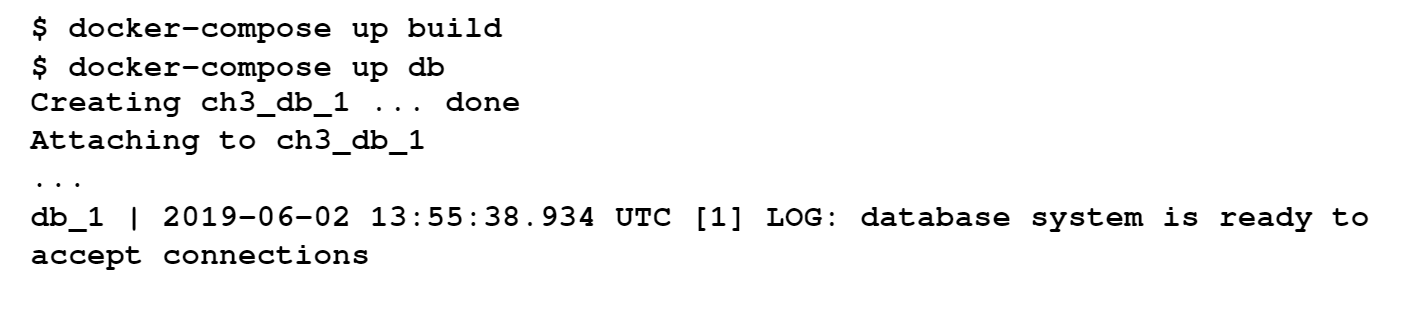

Ici, nous utilisons la variable d'environnement PGPASSWORD pour montrer que le mot de passe est celui précédemment configuré :

    PGPASSWORD=somepassword pgcli -h localhost -U postgres thoughts

## Configuration de votre service

Nous pouvons configurer le service pour utiliser des variables d'environnement pour modifier le comportement. Pour les conteneurs, c'est une alternative fantastique à l'utilisation de fichiers de configuration, car cela permet aux conteneurs immuables dont la configuration est injectée. Ceci est conforme aux principes de l'application Twelve-Factor (https://12factor.net/config) et permet une bonne séparation entre le code et la configuration, et la mise en place des différents déploiements pour lesquels le code peut être utilisé.

Cela permet la configuration de la base de données à laquelle se connecter, nous pouvons donc choisir entre le backend SQLite ou PostgreSQL.

Nous allons configurer les tests pour accéder à notre conteneur de base de données nouvellement créé. Pour ce faire, nous devons d'abord avoir la possibilité de choisir entre SQLite ou PostgreSQL via la configuration. Consultez le fichier ./ThoughtsBackend/thoughts_backend/db.py :


    import os
    from pathlib import Path
    from flask_sqlalchemy import SQLAlchemy

    DATABASE_ENGINE = os.environ.get('DATABASE_ENGINE', 'SQLITE')

    if DATABASE_ENGINE == 'SQLITE':
        dir_path = Path(os.path.dirname(os.path.realpath(__file__)))
        path = dir_path / '..'

        # Database initialisation
        FILE_PATH = f'{path}/db.sqlite3'
        DB_URI = 'sqlite+pysqlite:///{file_path}'
        db_config = {
            'SQLALCHEMY_DATABASE_URI': DB_URI.format(file_path=FILE_PATH),
            'SQLALCHEMY_TRACK_MODIFICATIONS': False,
        }

    elif DATABASE_ENGINE == 'POSTGRESQL':
        db_params = {
            'host': os.environ['POSTGRES_HOST'],
            'database': os.environ['POSTGRES_DB'],
            'user': os.environ['POSTGRES_USER'],
            'pwd': os.environ['POSTGRES_PASSWORD'],
            'port': os.environ['POSTGRES_PORT'],
        }
        DB_URI = 'postgresql://{user}:{pwd}@{host}:{port}/{database}'
        db_config = {
            'SQLALCHEMY_DATABASE_URI': DB_URI.format(**db_params),
            'SQLALCHEMY_TRACK_MODIFICATIONS': False,
        }

    else:
        raise Exception('Incorrect DATABASE_ENGINE')

    db = SQLAlchemy()



Lorsque vous utilisez la variable d'environnement DATABASE_ENGINE définie sur POSTGRESQL, elle la configurera correctement. Les autres variables d'environnement devront être correctes ; c'est-à-dire que si le moteur de base de données est défini sur PostgreSQL, la variable POSTGRES_HOST doit être configurée. 

Les variables d'environnement peuvent être stockées individuellement dans le fichier docker-compose.yaml, mais il est plus pratique d'en stocker plusieurs dans un fichier. Jetons un coup d'œil à environment.env :


DATABASE_ENGINE=POSTGRESQL
POSTGRES_DB=thoughts
POSTGRES_USER=postgres
POSTGRES_PASSWORD=somepassword
POSTGRES_PORT=5432
POSTGRES_HOST=db

Notez que la définition des utilisateurs, et ainsi de suite, est conforme aux arguments de createDockerfile pour les tests. POSTGRES_HOST est défini comme db, qui est le nom du service.

Notre service de test utilisant le conteneur PostgreSQL est alors défini comme suit :



    test-postgresql:
            env_file: environment.env
            environment:
                - PYTHONDONTWRITEBYTECODE=1
            build:
                dockerfile: docker/app/Dockerfile
                context: .
            entrypoint: pytest
            depends_on:
                - db
            volumes:
                - ./ThoughtsBackend:/opt/code


Ceci est très similaire au service test-sqlite, mais il ajoute la configuration de l'environnement dans environment.env et ajoute une dépendance sur db. Cela signifie que docker-compose démarrera le service db, s'il n'est pas présent.

Vous pouvez maintenant exécuter les tests sur la base de données PostgreSQL :

Une même image peut être taguée plusieurs fois, avec des tags différents. Par exemple, le dernier tag peut également être la version v1.5 :

    docker tag thoughts-backend:latest thoughts-backend:v1.5



Une fois le dépôt créé, nous devons baliser notre image en conséquence. Cela signifie qu'il doit inclure le nom d'utilisateur dans Docker Hub pour identifier le dépôt. Une alternative est de nommer l'image directement avec le nom d'utilisateur inclus



    docker tag thoughts-backend:latest jaimebuelta/thoughts-backend:latest

Pour pouvoir accéder au dépôt, nous devons nous connecter à Docker avec notre nom d'utilisateur et notre mot de passe dans Docker Hub :

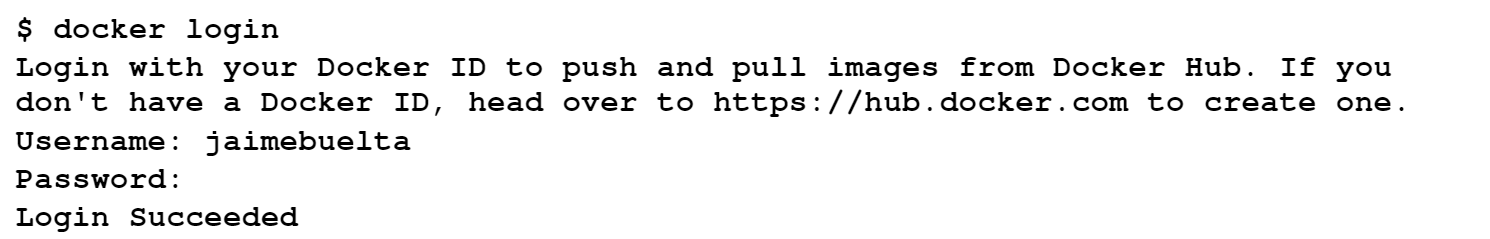






Une fois connecté, vous pouvez pousser votre image :

    docker push jaimebuelta/thoughts-backend:latest

    